# CHE 1148 Assignment 4
## 2. Data and model drift
    Build a monitoring tool that captures model quality and drift. 
 - Use all data prior to Dec-2013 (inclusively) to train a model; calculate the baseline distributions you need for the first point of the dashboard based on this timeframe.
 - Put this model in production; calculate the scores for all clients after Jan-2014 (inclusively).
 - capture the drift of the model scores and the top 5 features of the model once it goes in production on Jan-2014.

### 2.1 Prepare data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance

In [12]:
monthly_features_outputs = pd.read_excel('monthly_features_outputs.xlsx')

In [13]:
monthly_features_outputs

,Unnamed: 0.1,Unnamed: 0,customer_id,ME_DT,mth_txn_amt_sum,mth_txn_amt_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,0,157064,CS1112,2011-05-31,0,0,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,32,0
1,1,157058,CS1112,2011-06-30,56,1,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,1,15,0
2,2,157044,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,...,NaN,0,0,0,0,0,0,0,46,0
3,3,157069,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,...,NaN,1,0,0,0,0,0,0,12,0
4,4,157060,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,...,NaN,0,0,0,0,0,0,0,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,323543,295140,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,...,1.0,0,0,0,0,0,0,0,98,0
323544,323544,295126,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,...,1.0,0,0,0,0,0,0,0,129,0
323545,323545,295119,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,...,1.0,0,0,0,0,0,0,0,160,0
323546,323546,295136,CS9000,2015-02-28,34,1,34.0,11.333333,34.0,1.0,...,1.0,0,0,1,0,0,0,0,0,0


In [14]:
#drop uncessary columns for further training
X_y_monthly = monthly_features_outputs.drop(columns = ['Unnamed: 0.1','Unnamed: 0','customer_id'])

#seperate X with y according to date
X_y_baseline = X_y_monthly[X_y_monthly['ME_DT'] < '2014']  #data prior to Dec-2013 (inclusively)
X_y_target = X_y_monthly[X_y_monthly['ME_DT'] >= '2014']  #data after Jan-2014 (inclusively)

#get training data
X_baseline = X_y_baseline.drop(['response'], axis = 1).fillna(0)
y_baseline = X_y_baseline['response']

#get test data
X_target =  X_y_target.drop(['response'], axis = 1).fillna(0)
y_target = X_y_target['response']

In [19]:
#check time range 
print('Training dataset: from ',X_baseline['ME_DT'].min(),'to',X_baseline['ME_DT'].max())
print('Test dataset: from',X_target['ME_DT'].min(),'to',X_target['ME_DT'].max())

#check shapes
print('----------------------------------------------------')
print('Shape of traning dataset:',X_baseline.shape, y_baseline.shape)
print('Shape of target dataset:',X_target.shape, y_target.shape)

Training dataset: from  2011-05-31 00:00:00 to 2013-12-31 00:00:00
Test dataset: from 2014-01-31 00:00:00 to 2015-03-31 00:00:00
----------------------------------------------------
Shape of traning dataset: (220288, 29) (220288,)
Shape of target dataset: (103260, 29) (103260,)


### 2.2 Fit the data to the best best Random Forest (monthly) model  created in the previous assignment. 
Similarly, I choose the values of hyperparameters according to the tunned results from 1147 assignment, as I think the tunning result is better as more hyperparameters are involved.

In [131]:
RFC_monthly = RandomForestClassifier(random_state= 1148,class_weight= {0:1,1:10},
                                     max_features= 7,max_depth= 6,n_estimators=  50)

#Fit the training data, except the datatime column
X_baseline_new = X_baseline.drop(['ME_DT'], axis=1)
RFC_monthly.fit(X_baseline_new, y_baseline) 

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=6, max_features=7,
                       n_estimators=50, random_state=1148)

### 2.3 Create a dashboard
* includes the Jensen-Shannon divergence metric with the training data as baseline distributions
* monthly values after Jan-2014 for the following variables:
    1. the monthly scores
    2. the monthly top 5 features of the model

### 2.3.1 Monthly Scores
#### Baseline distribution of scores

In [132]:
import seaborn as sns
from scipy.spatial import distance

# calculate baseline scores
baseline_scores = RFC_monthly.predict_proba(X_baseline_new)[:,1]  
baseline_scores = baseline_scores/baseline_scores.max() # We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.

#use the quantile bins
bin_edges = np.quantile(baseline_scores, np.arange(0, 1.1, 0.1))
bin_edges[0]=0 # We replace the first element with zero since it's the lower cap
p = np.histogram(baseline_scores, bin_edges)

#### Monthly scores with Jensen-Shannon divergence metric (with the training data as baseline distributions)

In [133]:
#get each target month
target_months = pd.to_datetime(X_target['ME_DT']).unique()

#get js_score for each target month
js_scores = []
for m in target_months:
    # calculate target scores
    X_target_new = X_target[X_target['ME_DT']== m].drop(['ME_DT'], axis=1)
    target_scores = RFC_monthly.predict_proba(X_target_new)[:,1]  #default: bwteen 0 to 1 as probability
    target_scores = target_scores/target_scores.max() # We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.
    
    #use the quantile bins
    q = np.histogram(target_scores, bin_edges)
    js_score = distance.jensenshannon(p[0], q[0], 2.0)
    js_scores.append(js_score)
    
#store the values in a dataframe
js_monthly = pd.DataFrame({'date' : target_months,'js_score' : js_scores})
js_monthly

,date,js_score
0,2014-01-31,0.313748
1,2014-02-28,0.316120
2,2014-03-31,0.306944
3,2014-04-30,0.348344
4,2014-05-31,0.303422
5,2014-06-30,0.310425
6,2014-07-31,0.295767
7,2014-08-31,0.299985
8,2014-09-30,0.243335
9,2014-10-31,0.241441


Text(0, 0.5, 'Jensen-Shannon divergence value')

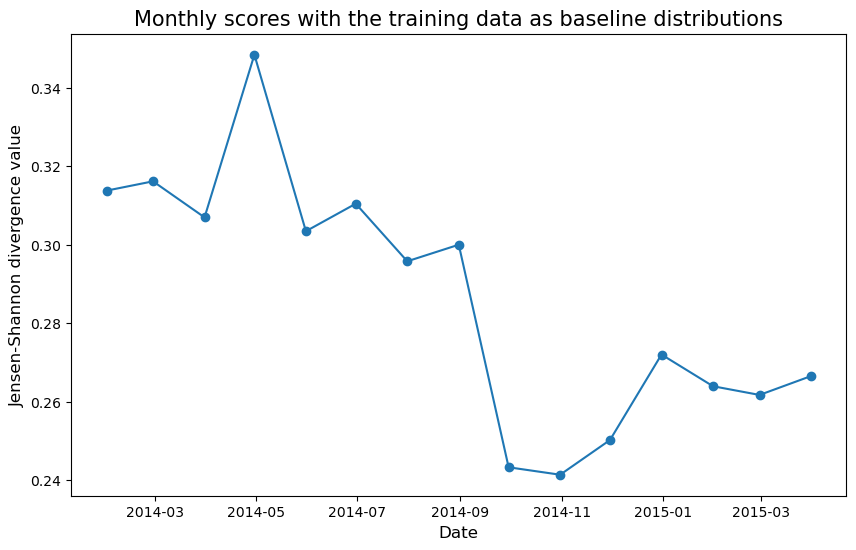

In [134]:
#visualize
plt.figure(figsize=[10,6])
plt.plot(js_monthly['date'], js_monthly['js_score'], marker='o')
plt.title('Monthly scores with the training data as baseline distributions',fontsize=15)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Jensen-Shannon divergence value',fontsize=12)

* Observations: sumarized at the end of the file




### 2.3.2 Monthly top 5 features of the model
#### Get top 5 fretaures

In [135]:
temp = abs(RFC_monthly.feature_importances_)
fea_importance = pd.DataFrame({'feature':X_target_new.columns,'importance':temp})
top_5_fea = fea_importance.sort_values(by=['importance'], ascending=False).iloc[:5]
top_5_fea

,feature,importance
16,amt_max_12M,0.146526
10,amt_max_6M,0.146097
14,amt_sum_12M,0.139216
15,amt_mean_12M,0.126632
9,amt_mean_6M,0.063514


#### Jensen-Shannon divergence score of top_5 features with the training data as baseline distributions 

In [138]:
#get each target month
top_5 = top_5_fea['feature'].unique()
js_scores_lst =[]

#get js_score for each target month
for fea in top_5:
    js_scores = []
    # calculate baseline scores, get rid of max_features= 7
    RFC_fea = RandomForestClassifier(random_state= 1148,class_weight= {0:1,1:10},
                                     max_depth= 6,n_estimators= 50)

    #Fit the training data
    RFC_fea.fit(X_baseline[[fea]], y_baseline) 
    
    #calculate baseline score
    baseline_scores = RFC_fea.predict_proba(X_baseline[[fea]])[:,1]  
    baseline_scores = baseline_scores/baseline_scores.max() # We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.

    #use the quantile bins
    bin_edges = np.quantile(baseline_scores, np.arange(0, 1.1, 0.1))
    bin_edges[0]=0 # We replace the first element with zero since it's the lower cap
    p = np.histogram(baseline_scores, bin_edges)

    for m in target_months:
        # calculate target scores
        X_target_new = X_target[[fea]][X_target['ME_DT']== m]
        target_scores = RFC_fea.predict_proba(X_target_new)[:,1]  #default: bwteen 0 to 1 as probability
        target_scores = target_scores/target_scores.max() # We divide by the .max() value to ensure that the upper limit is 1 since it's supposed to be a probability score.

        #use the quantile bins
        q = np.histogram(target_scores, bin_edges)
        js_score = distance.jensenshannon(p[0], q[0], 2.0)
        js_scores.append(js_score)
    #append each js_scores lst to a larger lst
    js_scores_lst.append(js_scores)

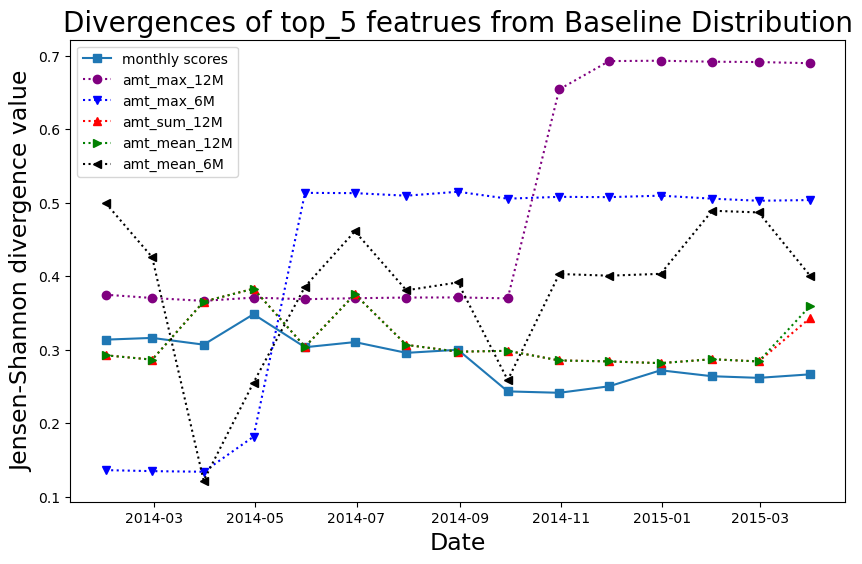

In [139]:
# visualize
plt.figure(figsize=[10,6])
markers = ['o','v','^','>','<']
colors = ['purple','blue','red','green','black']

#monthly scores
plt.plot(js_monthly['date'], js_monthly['js_score'], label ='monthly scores', marker='s')

#monthly top 5 features of the model
for i in range(5):
    plt.plot(target_months, js_scores_lst[i], label =top_5[i], marker=markers[i],color=colors[i],linestyle = 'dotted')
plt.title("Divergences of top_5 featrues from Baseline Distribution",fontsize=20)
plt.xlabel("Date",fontsize=17)
plt.ylabel("Jensen-Shannon divergence value",fontsize=17)
plt.legend(loc="upper left")
plt.show()

### Observations:

From the plot above, compare with the baseline distribution - all data prior to Dec-2013 (inclusively):

* The monthly scores are not high, with all values around 0.3, and the trend is smooth, indicating for all clients after Jan-2014 (inclusively), there are no obvious turning point and the difference during the production period are simimlar with the baseline distribution.

* The two lines conneting the value points of amt_mean_12_M and amt_mean_12M show the similar patterns with the monhtlyn scores, even though with slighly higher values and some fluctuations.

* amt_mean_6M shows a significant drifts in 2014-04, and the values keep to be much higher from the time point here. Besides, there is a obvious drift in 2014-10 for amt_max_12M, with the rising of scores from 2016-10, which means at this time points, there are some factors causing the customers' buying behavior.

* amt_max_6M sshows a significant drifts in 2014-06, but the value is back to higehr level after that, this sudden change may be caused by poor performance of model, or potential reason affecting the buying behavior.
